# Week 11 – DBSCAN and Hierarchical Clustering on CKD Dataset

This notebook applies **DBSCAN** and **Hierarchical Agglomerative Clustering (HAC)** to the Chronic Kidney Disease dataset to identify patient subgroups based on numeric clinical features.




In [1]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

DATA_PATH = "Chronic_Kidney_Dsease_data.csv"

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(1659, 54)


,PatientID,Age,Gender,Ethnicity,SocioeconomicStatus,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,...,Itching,QualityOfLifeScore,HeavyMetalsExposure,OccupationalExposureChemicals,WaterQuality,MedicalCheckupsFrequency,MedicationAdherence,HealthLiteracy,Diagnosis,DoctorInCharge
0,1,71,0,0,0,2,31.069414,1,5.128112,1.676220,...,7.556302,76.076800,0,0,1,1.018824,4.966808,9.871449,1,Confidential
1,2,34,0,0,1,3,29.692119,1,18.609552,8.377574,...,6.836766,40.128498,0,0,0,3.923538,8.189275,7.161765,1,Confidential
2,3,80,1,1,0,1,37.394822,1,11.882429,9.607401,...,2.144722,92.872842,0,1,1,1.429906,7.624028,7.354632,1,Confidential
3,4,40,0,2,0,1,31.329680,0,16.020165,0.408871,...,7.077188,90.080321,0,0,0,3.226416,3.282688,6.629587,1,Confidential
4,5,43,0,1,1,2,23.726311,0,7.944146,0.780319,...,3.553118,5.258372,0,0,1,0.285466,3.849498,1.437385,1,Confidential


## Select Numeric Features and Preprocess

In [11]:
df = df.drop(columns=["PatientID", "DoctorInCharge"], errors="ignore")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if "Diagnosis" in numeric_cols:
    numeric_cols.remove("Diagnosis")
X = df[numeric_cols].copy()
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
X_scaled = pipe.fit_transform(X)
print("Numeric feature shape:", X_scaled.shape) 

Numeric feature shape: (1659, 51)


## DBSCAN – k-distance Plot for Choosing ε

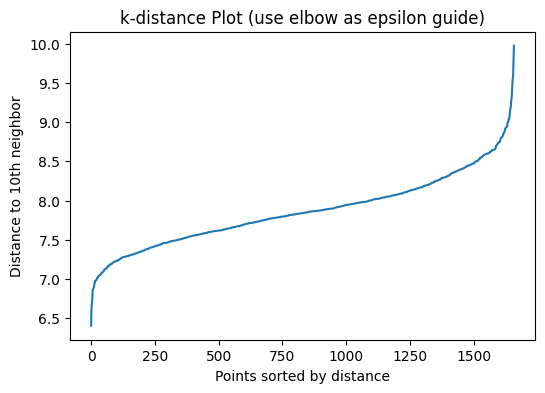

In [3]:
# Use NearestNeighbors to help choose epsilon (k-distance graph)
k = 10
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort distances to kth nearest neighbor
distances_k = np.sort(distances[:, -1])

plt.figure(figsize=(6, 4))
plt.plot(distances_k)
plt.ylabel(f"Distance to {k}th neighbor")
plt.xlabel("Points sorted by distance")
plt.title("k-distance Plot (use elbow as epsilon guide)")
plt.show()

## DBSCAN Clustering

In [4]:
# Example epsilon/min_samples values – adjust based on k-distance plot
eps_values = [0.8, 1.0, 1.2]
min_samples = 10

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    print(f"eps={eps}: clusters={n_clusters}, noise points={n_noise}")
    
    # Compute silhouette only if at least 2 clusters
    if n_clusters >= 2:
        mask = labels != -1
        sil = silhouette_score(X_scaled[mask], labels[mask])
        print(f"  Silhouette (excluding noise): {sil:.3f}")
    print()

eps=0.8: clusters=0, noise points=1659

eps=1.0: clusters=0, noise points=1659

eps=1.2: clusters=0, noise points=1659



## Hierarchical Agglomerative Clustering (HAC)

In [5]:
# Try HAC with a small number of clusters
for n_clusters in [2, 3, 4]:
    hac = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    labels = hac.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    print(f"HAC with {n_clusters} clusters – silhouette: {sil:.3f}")

HAC with 2 clusters – silhouette: 0.101
HAC with 3 clusters – silhouette: 0.042
HAC with 4 clusters – silhouette: 0.037


### Dendrogram (on a Random Subset for Clarity)

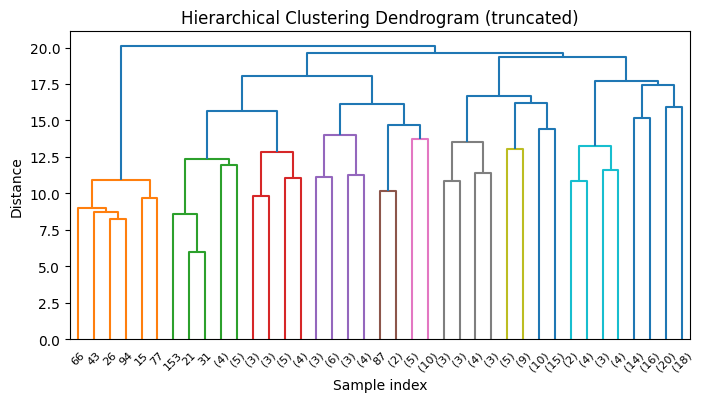

In [6]:
# For dendrograms, use a smaller random sample to keep it readable
np.random.seed(42)
sample_idx = np.random.choice(X_scaled.shape[0], size=min(200, X_scaled.shape[0]), replace=False)
X_sample = X_scaled[sample_idx]

Z = linkage(X_sample, method="ward")

plt.figure(figsize=(8, 4))
dendrogram(Z, truncate_mode="level", p=5)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

## Interpreting Clusters with Diagnosis

In [8]:
# Example: fit HAC with 3 clusters and compare to Diagnosis
hac3 = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels3 = hac3.fit_predict(X_scaled)

if "Diagnosis" in df.columns:
    ctab = pd.crosstab(labels3, df["Diagnosis"], rownames=["Cluster"], colnames=["Diagnosis"])
    print(ctab)

Diagnosis    0     1
Cluster             
0          118  1357
1            5    68
2           12    99
